# 🎨 Diffusion Models from Scratch: Your Deep Learning Mentor

Welcome to your interactive journey into **Diffusion Models**! 

## What You'll Learn

Diffusion models are the technology behind:
- **DALL-E 2/3** - Text to image generation
- **Stable Diffusion** - Open-source image synthesis  
- **Midjourney** - AI art generation
- **Sora** - Video generation

### The Big Idea 💡

Diffusion models work in two phases:
1. **Forward Process**: Gradually add noise to an image until it becomes pure random noise
2. **Reverse Process**: Learn to remove noise step-by-step to generate new images

Think of it like this:
- Forward: Dropping ink into water 💧 → 🌫️ (organized → chaotic)
- Reverse: Learning to "unblur" the ink back into a drop 🌫️ → 💧 (chaotic → organized)

### Why Diffusion Models Work So Well

Unlike GANs (which have training instability) or VAEs (which produce blurry images), diffusion models:
- **Train stably**: Simple MSE loss, no adversarial training
- **Produce high-quality samples**: State-of-the-art image quality
- **Have theoretical grounding**: Based on thermodynamics and score matching
- **Scale well**: Performance improves predictably with more compute

### Historical Context 📜

| Year | Milestone |
|------|-----------|
| 2015 | Sohl-Dickstein et al. introduce diffusion probabilistic models |
| 2020 | Ho et al. publish DDPM - makes diffusion practical |
| 2021 | Nichol & Dhariwal show diffusion beats GANs on ImageNet |
| 2022 | Stable Diffusion released - democratizes AI art |
| 2023+ | Diffusion dominates: DALL-E 3, Midjourney v5, Sora |

Let's build this from scratch!

## Section 1: Import Required Libraries

First, let's import everything we need. We'll use:
- **PyTorch** - Our deep learning framework (tensors, autograd, neural networks)
- **torchvision** - For datasets (MNIST) and image utilities
- **matplotlib** - For visualizations and diagrams
- **numpy** - For numerical operations outside of PyTorch
- **tqdm** - For progress bars during training

### Why PyTorch?

PyTorch is ideal for learning because:
1. **Dynamic computation graphs** - Easier to debug and understand
2. **Pythonic** - Feels natural to Python developers
3. **Research standard** - Most diffusion papers use PyTorch
4. **GPU acceleration** - Seamless CUDA support

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from tqdm import tqdm  # Use standard tqdm (no ipywidgets dependency)
import math

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Visualization settings
plt.style.use('default')
%matplotlib inline

🖥️ Using device: cuda


/tmp/ipykernel_22946/1610268953.py:52: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


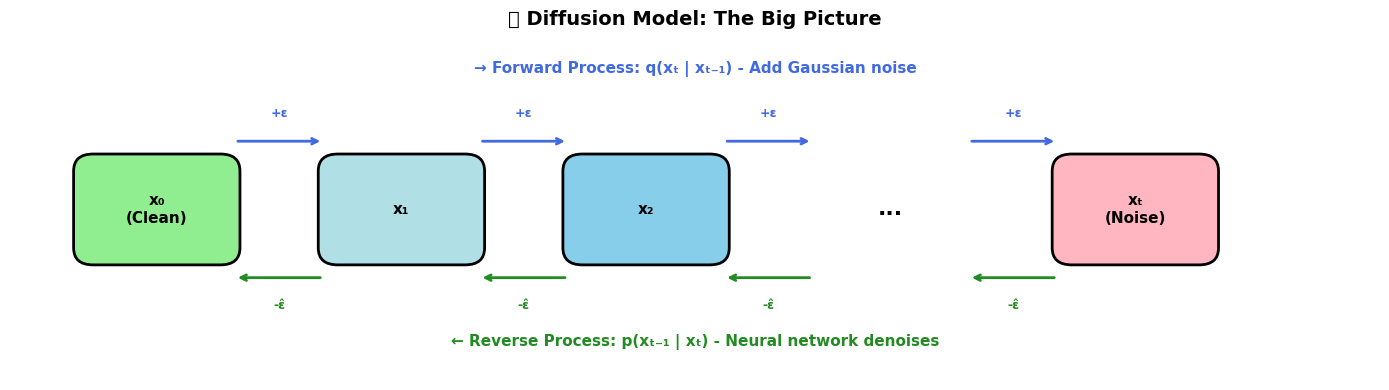

In [13]:
# Visualize the Diffusion Process Architecture using matplotlib
def create_diffusion_overview():
    """Create a diagram showing the high-level diffusion process."""
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 4)
    ax.axis('off')
    
    # Node positions and labels
    nodes = [
        (1.5, 2, 'x₀\n(Clean)', '#90EE90'),
        (4, 2, 'x₁', '#B0E0E6'),
        (6.5, 2, 'x₂', '#87CEEB'),
        (9, 2, '...', 'white'),
        (11.5, 2, 'xₜ\n(Noise)', '#FFB6C1'),
    ]
    
    # Draw nodes
    for x, y, label, color in nodes:
        if label == '...':
            ax.text(x, y, label, ha='center', va='center', fontsize=16, fontweight='bold')
        else:
            box = FancyBboxPatch((x-0.8, y-0.6), 1.6, 1.2, 
                                  boxstyle="round,pad=0.05,rounding_size=0.2",
                                  facecolor=color, edgecolor='black', linewidth=2)
            ax.add_patch(box)
            ax.text(x, y, label, ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Draw forward arrows (top)
    arrow_y = 2.8
    for i, (x1, x2) in enumerate([(2.3, 3.2), (4.8, 5.7), (7.3, 8.2), (9.8, 10.7)]):
        ax.annotate('', xy=(x2, arrow_y), xytext=(x1, arrow_y),
                   arrowprops=dict(arrowstyle='->', color='#4169E1', lw=2))
        ax.text((x1+x2)/2, arrow_y+0.25, '+ε', ha='center', va='bottom', 
               fontsize=9, color='#4169E1', fontweight='bold')
    
    # Draw reverse arrows (bottom)
    arrow_y = 1.2
    for i, (x1, x2) in enumerate([(3.2, 2.3), (5.7, 4.8), (8.2, 7.3), (10.7, 9.8)]):
        ax.annotate('', xy=(x2, arrow_y), xytext=(x1, arrow_y),
                   arrowprops=dict(arrowstyle='->', color='#228B22', lw=2))
        ax.text((x1+x2)/2, arrow_y-0.25, '-ε̂', ha='center', va='top', 
               fontsize=9, color='#228B22', fontweight='bold')
    
    # Labels
    ax.text(7, 3.6, '→ Forward Process: q(xₜ | xₜ₋₁) - Add Gaussian noise', 
           ha='center', fontsize=11, color='#4169E1', fontweight='bold')
    ax.text(7, 0.4, '← Reverse Process: p(xₜ₋₁ | xₜ) - Neural network denoises', 
           ha='center', fontsize=11, color='#228B22', fontweight='bold')
    
    plt.title('📊 Diffusion Model: The Big Picture', fontsize=14, fontweight='bold', pad=10)
    plt.tight_layout()
    return fig

# Display the overview diagram
fig = create_diffusion_overview()
plt.show()

## Section 2: Understanding the Mathematical Foundation

### The Noise Schedule 📊

The **noise schedule** is the heart of diffusion models. It defines how quickly we corrupt data with noise.

At each timestep $t \in \{0, 1, ..., T-1\}$, we define:

| Symbol | Name | Meaning | Typical Range |
|--------|------|---------|---------------|
| $\beta_t$ | Beta | Variance of noise added at step $t$ | 0.0001 → 0.02 |
| $\alpha_t = 1 - \beta_t$ | Alpha | Signal retention per step | 0.9999 → 0.98 |
| $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$ | Alpha-bar | **Cumulative** signal remaining | 1.0 → ~0.0 |

### Why is $\bar{\alpha}_t$ (alpha-bar) the most important?

$\bar{\alpha}_t$ tells us the **total amount of original signal remaining** after $t$ steps:

- At $t=0$: $\bar{\alpha}_0 \approx 1.0$ → Image is almost clean
- At $t=500$: $\bar{\alpha}_{500} \approx 0.1$ → Mostly noise, some structure
- At $t=999$: $\bar{\alpha}_{999} \approx 0.0$ → Pure noise, no signal

### Linear vs Cosine Schedule

**Linear Schedule** (original DDPM):
- $\beta_t$ increases linearly from $\beta_1$ to $\beta_T$
- Simple but signal drops too fast at the beginning
- Fine for low-resolution images (32×32, 64×64)

**Cosine Schedule** (Improved DDPM):
- $\bar{\alpha}_t$ follows a cosine curve
- Smoother signal decay, better for high-resolution
- Prevents "wasting" early timesteps on already-noisy images

### The Key Insight 🔑

We don't need to add noise step-by-step! We can jump directly to any timestep using:
$$x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon$$

This is crucial for efficient training!

In [8]:
# Define the noise schedule
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    """
    Linear schedule from Ho et al. (2020) DDPM paper.
    
    beta_t increases linearly from beta_start to beta_end.
    """
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule from Nichol & Dhariwal (2021).
    
    Provides smoother noise levels, especially at the start.
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clamp(betas, 0.0001, 0.9999)

# Number of diffusion steps
T = 1000  # This is a hyperparameter - more steps = better quality but slower

# Create schedules
betas_linear = linear_beta_schedule(T)
betas_cosine = cosine_beta_schedule(T)

# Compute derived quantities for linear schedule
betas = betas_linear
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)  # ᾱ_t

print(f"📊 Schedule created with {T} timesteps")
print(f"   β ranges from {betas[0]:.6f} to {betas[-1]:.4f}")
print(f"   ᾱ ranges from {alphas_cumprod[0]:.4f} to {alphas_cumprod[-1]:.6f}")

📊 Schedule created with 1000 timesteps
   β ranges from 0.000100 to 0.0200
   ᾱ ranges from 0.9999 to 0.000040


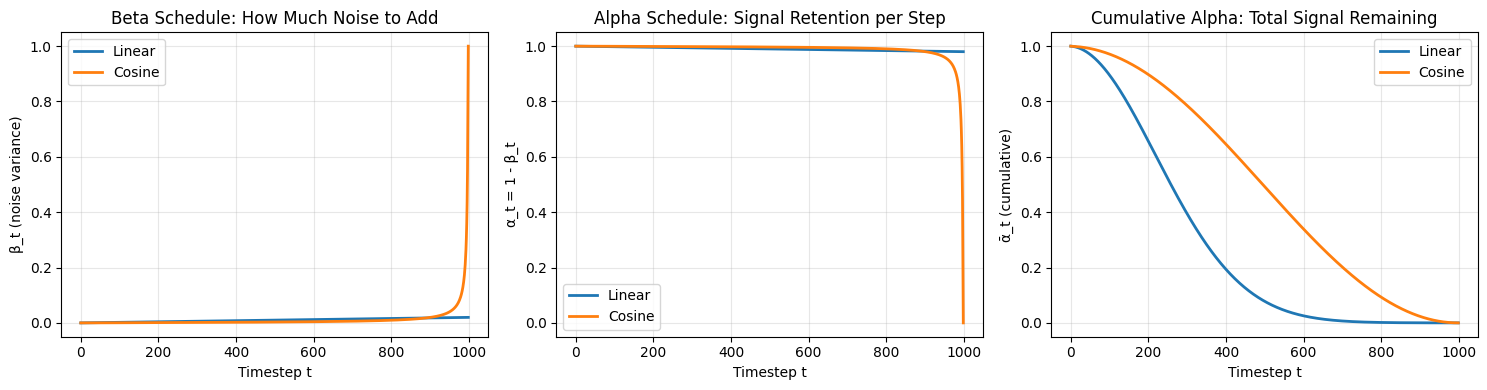


🔍 Key Insight:
   - Linear schedule: Signal drops quickly, most noise added early
   - Cosine schedule: Smoother decay, better for high-resolution images


In [9]:
# Visualize the noise schedules
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Beta schedule comparison
axes[0].plot(betas_linear.numpy(), label='Linear', linewidth=2)
axes[0].plot(betas_cosine.numpy(), label='Cosine', linewidth=2)
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('β_t (noise variance)')
axes[0].set_title('Beta Schedule: How Much Noise to Add')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Alpha schedule
alphas_linear = 1 - betas_linear
alphas_cosine = 1 - betas_cosine
axes[1].plot(alphas_linear.numpy(), label='Linear', linewidth=2)
axes[1].plot(alphas_cosine.numpy(), label='Cosine', linewidth=2)
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('α_t = 1 - β_t')
axes[1].set_title('Alpha Schedule: Signal Retention per Step')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Cumulative alpha (most important!)
alphas_cumprod_linear = torch.cumprod(alphas_linear, dim=0)
alphas_cumprod_cosine = torch.cumprod(alphas_cosine, dim=0)
axes[2].plot(alphas_cumprod_linear.numpy(), label='Linear', linewidth=2)
axes[2].plot(alphas_cumprod_cosine.numpy(), label='Cosine', linewidth=2)
axes[2].set_xlabel('Timestep t')
axes[2].set_ylabel('ᾱ_t (cumulative)')
axes[2].set_title('Cumulative Alpha: Total Signal Remaining')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🔍 Key Insight:")
print("   - Linear schedule: Signal drops quickly, most noise added early")
print("   - Cosine schedule: Smoother decay, better for high-resolution images")

## Section 3: Implement Forward Diffusion Process

### The Magic Equation ✨

The forward process defines how we **add noise** to clean data. Given a clean image $x_0$, we want to get a noisy version $x_t$ at any timestep $t$.

**The forward distribution** (from probability theory):
$$q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} \cdot x_0, (1 - \bar{\alpha}_t) \cdot I)$$

This says: "$x_t$ is drawn from a Gaussian with mean $\sqrt{\bar{\alpha}_t} \cdot x_0$ and variance $(1 - \bar{\alpha}_t)$"

### The Reparameterization Trick 🎯

Instead of sampling from the distribution, we can **compute $x_t$ directly**:

$$\boxed{x_t = \sqrt{\bar{\alpha}_t} \cdot x_0 + \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon}$$

where $\epsilon \sim \mathcal{N}(0, I)$ is random Gaussian noise.

### Intuition: Signal-to-Noise Decomposition

Think of $x_t$ as a weighted sum of **signal** and **noise**:

| Component | Formula | At t=0 | At t=T |
|-----------|---------|--------|--------|
| Signal weight | $\sqrt{\bar{\alpha}_t}$ | ≈ 1.0 | ≈ 0.0 |
| Noise weight | $\sqrt{1 - \bar{\alpha}_t}$ | ≈ 0.0 | ≈ 1.0 |

As $t$ increases:
- Signal coefficient shrinks → original image fades
- Noise coefficient grows → random noise dominates

### Why This Formulation?

1. **Mathematically elegant**: Variance is preserved (signal² + noise² ≈ 1)
2. **Efficient training**: Jump to any $t$ in O(1) time
3. **Gradient-friendly**: Reparameterization allows backprop through sampling

### The `extract()` Function

The most important utility in diffusion code! It:
1. Takes a 1D schedule tensor of shape `(T,)`
2. Extracts values at batch of timesteps `t` of shape `(B,)`
3. Reshapes to `(B, 1, 1, 1)` for broadcasting with images `(B, C, H, W)`

In [24]:
# Pre-compute useful quantities for the forward process
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

def extract(a, t, x_shape):
    """
    Extract values from 'a' at indices 't' and reshape for broadcasting.
    
    This is THE most important utility function in diffusion models!
    
    Args:
        a: 1D tensor of values (e.g., sqrt_alphas_cumprod) shape: (T,)
        t: Batch of timestep indices, shape: (B,)
        x_shape: Shape of x, e.g., (B, C, H, W)
    
    Returns:
        Values reshaped to (B, 1, 1, 1) for broadcasting
    """
    batch_size = t.shape[0]
    # Move schedule tensor to the same device as t
    out = a.to(t.device).gather(-1, t)  # Get values at indices t
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def q_sample(x_0, t, noise=None):
    """
    Forward diffusion: Add noise to x_0 to get x_t.
    
    x_t = sqrt(ᾱ_t) * x_0 + sqrt(1 - ᾱ_t) * ε
    
    Args:
        x_0: Original clean images, shape (B, C, H, W)
        t: Timesteps, shape (B,)
        noise: Optional pre-sampled noise
    
    Returns:
        x_t: Noisy images at timestep t
        noise: The noise that was added
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    
    # Get the scaling factors for each sample in the batch
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    
    # Apply the forward process equation
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    
    return x_t, noise

print("✅ Forward process functions defined!")

✅ Forward process functions defined!


In [15]:
# Load a sample dataset to visualize (MNIST is simple and fast)
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1),  # Normalize to [-1, 1]
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Get a batch of images
sample_batch, labels = next(iter(dataloader))
print(f"📷 Loaded sample batch: {sample_batch.shape}")
print(f"   Value range: [{sample_batch.min():.2f}, {sample_batch.max():.2f}]")

📷 Loaded sample batch: torch.Size([16, 1, 32, 32])
   Value range: [-1.00, 1.00]


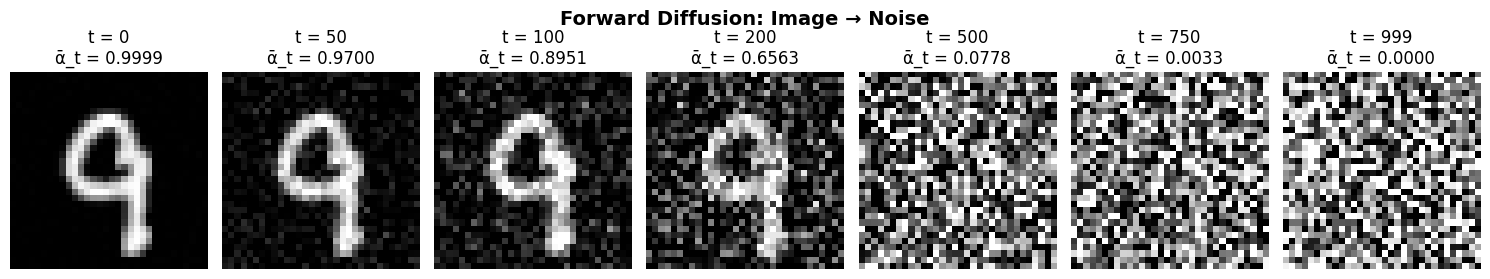


🔍 Observation:
   - t=0: Original image (clean)
   - t=500: Roughly half noise, half signal
   - t=999: Almost pure noise (barely visible structure)


In [16]:
# Visualize the forward diffusion process
def show_forward_diffusion(image, timesteps_to_show):
    """Visualize how an image gets noisier over time."""
    fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(15, 3))
    
    for idx, t in enumerate(timesteps_to_show):
        t_tensor = torch.tensor([t])
        noisy_img, noise = q_sample(image.unsqueeze(0), t_tensor)
        
        # Convert to displayable format
        img = noisy_img[0, 0].numpy()  # Remove batch and channel dims
        img = (img + 1) / 2  # Convert from [-1,1] to [0,1]
        img = np.clip(img, 0, 1)
        
        axes[idx].imshow(img, cmap='gray')
        axes[idx].set_title(f't = {t}\nᾱ_t = {alphas_cumprod[t]:.4f}')
        axes[idx].axis('off')
    
    plt.suptitle('Forward Diffusion: Image → Noise', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Show a single image being noised
single_image = sample_batch[0]  # Take first image
timesteps_to_show = [0, 50, 100, 200, 500, 750, 999]
show_forward_diffusion(single_image, timesteps_to_show)

print("\n🔍 Observation:")
print("   - t=0: Original image (clean)")
print("   - t=500: Roughly half noise, half signal")  
print("   - t=999: Almost pure noise (barely visible structure)")

## Section 4: Implement Reverse Diffusion Process

### Learning to Denoise 🎯

The reverse process is where the **magic** happens! We train a neural network to undo the noise addition.

**The Goal**: Given noisy image $x_t$ and timestep $t$, predict what was added so we can remove it.

### What Does the Model Learn?

We have a choice of what to predict:

| Prediction Target | Pros | Cons |
|-------------------|------|------|
| $x_0$ (clean image) | Direct output | Hard at high noise |
| $\epsilon$ (noise) | Simpler statistics | Standard choice ✓ |
| $v$ (velocity) | Better for some tasks | More complex |

**DDPM predicts the noise $\epsilon$** - this works surprisingly well!

### The Reverse Distribution

The reverse process is also Gaussian:
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

The model predicts the **mean** $\mu_\theta$:
$$\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right)$$

### Why Predict Noise Instead of the Image?

1. **Easier optimization**: Noise has simpler statistics (zero mean, unit variance)
2. **Better gradients**: Loss landscape is smoother
3. **Scale invariance**: Same approach works for all noise levels
4. **Empirically better**: Ho et al. (2020) showed this works best

### The Posterior Variance

The variance $\sigma_t^2$ can be:
- **Fixed**: Use $\beta_t$ or $\tilde{\beta}_t = \frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t}\beta_t$
- **Learned**: Let the network predict it (Improved DDPM)

For simplicity, we use fixed variance in this tutorial.

### Denoising Step Algorithm

```
Input: x_t (noisy), t (timestep), model
1. Predict noise: ε̂ = model(x_t, t)
2. Compute mean: μ = (1/√αₜ)(xₜ - βₜ/√(1-ᾱₜ)·ε̂)
3. Sample: x_{t-1} = μ + σₜ·z, where z ~ N(0,I)
4. Return: x_{t-1}
```

In [17]:
# Pre-compute quantities needed for the reverse process
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

# Posterior variance: β̃_t = β_t * (1 - ᾱ_{t-1}) / (1 - ᾱ_t)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

# For computing the mean
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

@torch.no_grad()
def p_sample(model, x_t, t, t_index):
    """
    Single reverse diffusion step: x_t → x_{t-1}
    
    Args:
        model: Neural network that predicts noise
        x_t: Current noisy image
        t: Current timestep (batch tensor)
        t_index: Current timestep (integer)
    
    Returns:
        x_{t-1}: Slightly denoised image
    """
    # Model predicts the noise
    predicted_noise = model(x_t, t)
    
    # Get schedule values for this timestep
    betas_t = extract(betas, t, x_t.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_t.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x_t.shape)
    
    # Compute the mean of p(x_{t-1} | x_t)
    # μ_θ = (1/√α_t) * (x_t - (β_t/√(1-ᾱ_t)) * ε_θ)
    model_mean = sqrt_recip_alphas_t * (
        x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )
    
    if t_index == 0:
        # Final step: return the mean (no noise added)
        return model_mean
    else:
        # Add noise scaled by posterior variance
        posterior_variance_t = extract(posterior_variance, t, x_t.shape)
        noise = torch.randn_like(x_t)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample(model, image_size, channels=1, batch_size=16):
    """
    Generate images by running the full reverse process.
    
    Start from pure noise x_T ~ N(0, I) and iteratively denoise.
    """
    shape = (batch_size, channels, image_size, image_size)
    
    # Start from pure noise
    x = torch.randn(shape, device=device)
    
    # Iteratively denoise: t = T-1, T-2, ..., 0
    for t_index in tqdm(reversed(range(T)), desc='Sampling', total=T):
        t = torch.full((batch_size,), t_index, device=device, dtype=torch.long)
        x = p_sample(model, x, t, t_index)
    
    return x

print("✅ Reverse process functions defined!")

✅ Reverse process functions defined!


## Section 5: Build the Noise Prediction Network (U-Net)

### Why U-Net? 🏗️

The U-Net architecture is perfect for diffusion because:

| Property | Why It Matters |
|----------|----------------|
| **Encoder-Decoder** | Captures features at multiple scales |
| **Skip Connections** | Preserves fine details (textures, edges) |
| **Fully Convolutional** | Works with any image size |
| **Proven** | Originally designed for image segmentation |

### Key Components

#### 1. Sinusoidal Position Embeddings (Time Encoding)

Just like Transformers encode position, we encode **timestep**:
$$PE(t, i) = \begin{cases} \sin(t / 10000^{2i/d}) & \text{if } i \text{ is even} \\ \cos(t / 10000^{2i/d}) & \text{if } i \text{ is odd} \end{cases}$$

This gives each timestep a **unique fingerprint** that the network can recognize.

#### 2. Residual Blocks with Time Injection

Each ResNet block:
1. Processes spatial features with convolutions
2. **Injects time embedding** by adding it to intermediate features
3. Uses skip connections for stable gradients

```
x → Conv → Norm → SiLU → (+time_emb) → Conv → Norm → SiLU → (+skip) → out
```

#### 3. Self-Attention Layers

At lower resolutions (e.g., 8×8), we add **self-attention** to capture:
- Global context (object relationships)
- Long-range dependencies
- Coherent structure generation

#### 4. GroupNorm (not BatchNorm!)

We use **GroupNorm** because:
- Works with small batch sizes (common in diffusion)
- More stable for generative models
- Doesn't depend on batch statistics

### Architecture Overview

```
Input (B, C, 32, 32)
    ↓
[Encoder] 64→128→256 channels, spatial 32→16→8
    ↓
[Bottleneck] 256 channels + Self-Attention
    ↓
[Decoder] 256→128→64 channels, spatial 8→16→32
    ↓
Output (B, C, 32, 32) ← Predicted noise
```

Each level receives **time embeddings** and has **skip connections** to corresponding encoder level.

/tmp/ipykernel_22946/22035758.py:90: UserWarning: Glyph 127959 (\N{BUILDING CONSTRUCTION}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22946/22035758.py:90: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22946/22035758.py:90: UserWarning: Glyph 128995 (\N{LARGE PURPLE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22946/22035758.py:90: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22946/22035758.py:90: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


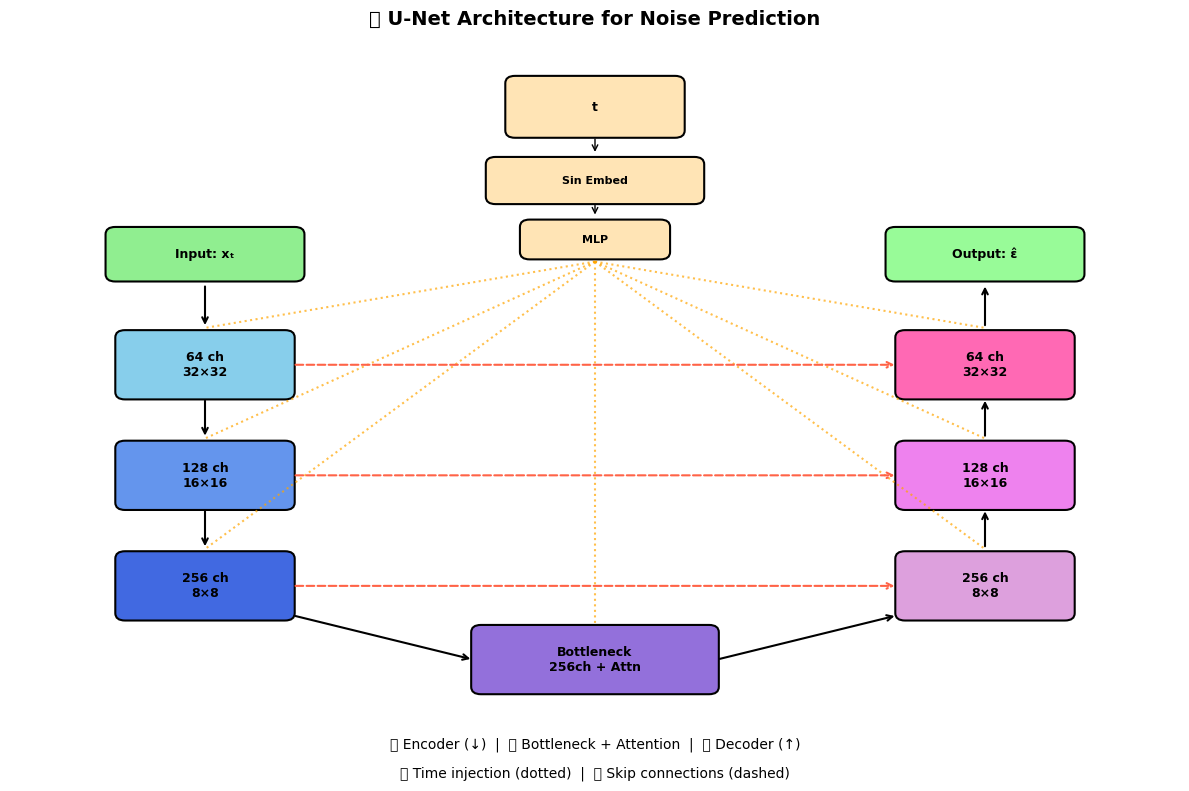

In [23]:
# Visualize U-Net Architecture using matplotlib
def create_unet_diagram():
    """Create a diagram showing the U-Net architecture for diffusion."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    def draw_box(x, y, w, h, label, color, fontsize=9):
        box = FancyBboxPatch((x-w/2, y-h/2), w, h,
                              boxstyle="round,pad=0.02,rounding_size=0.1",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(box)
        ax.text(x, y, label, ha='center', va='center', fontsize=fontsize, fontweight='bold')
    
    # Time embedding (top)
    draw_box(6, 9, 1.8, 0.8, 't', '#FFE4B5')
    draw_box(6, 8, 2.2, 0.6, 'Sin Embed', '#FFE4B5', 8)
    draw_box(6, 7.2, 1.5, 0.5, 'MLP', '#FFE4B5', 8)
    ax.annotate('', xy=(6, 8.35), xytext=(6, 8.6), arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('', xy=(6, 7.5), xytext=(6, 7.7), arrowprops=dict(arrowstyle='->', color='black'))
    
    # Encoder (left side)
    encoder_nodes = [
        (2, 5.5, '64 ch\n32×32', '#87CEEB'),
        (2, 4, '128 ch\n16×16', '#6495ED'),
        (2, 2.5, '256 ch\n8×8', '#4169E1'),
    ]
    
    # Bottleneck
    draw_box(6, 1.5, 2.5, 0.9, 'Bottleneck\n256ch + Attn', '#9370DB')
    
    # Decoder (right side)
    decoder_nodes = [
        (10, 2.5, '256 ch\n8×8', '#DDA0DD'),
        (10, 4, '128 ch\n16×16', '#EE82EE'),
        (10, 5.5, '64 ch\n32×32', '#FF69B4'),
    ]
    
    # Draw encoder
    for x, y, label, color in encoder_nodes:
        draw_box(x, y, 1.8, 0.9, label, color)
    
    # Draw decoder
    for x, y, label, color in decoder_nodes:
        draw_box(x, y, 1.8, 0.9, label, color)
    
    # Input/Output
    draw_box(2, 7, 2, 0.7, 'Input: xₜ', '#90EE90')
    draw_box(10, 7, 2, 0.7, 'Output: ε̂', '#98FB98')
    
    # Encoder arrows (down): from input through encoder to bottleneck
    # Arrow from Input to first encoder block
    ax.annotate('', xy=(2, 6), xytext=(2, 6.6), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from first encoder to second encoder
    ax.annotate('', xy=(2, 4.5), xytext=(2, 5.05), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from second encoder to third encoder
    ax.annotate('', xy=(2, 3), xytext=(2, 3.55), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from third encoder to bottleneck
    ax.annotate('', xy=(4.75, 1.5), xytext=(2.9, 2.1), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Decoder arrows (up): from bottleneck through decoder to output
    # Arrow from bottleneck to first decoder block
    ax.annotate('', xy=(9.1, 2.1), xytext=(7.25, 1.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from first decoder to second decoder
    ax.annotate('', xy=(10, 3.55), xytext=(10, 3), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from second decoder to third decoder
    ax.annotate('', xy=(10, 5.05), xytext=(10, 4.5), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    # Arrow from third decoder to output
    ax.annotate('', xy=(10, 6.6), xytext=(10, 6), arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Skip connections (dashed red)
    skip_pairs = [(2.9, 5.5, 9.1, 5.5), (2.9, 4, 9.1, 4), (2.9, 2.5, 9.1, 2.5)]
    for x1, y1, x2, y2 in skip_pairs:
        ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                   arrowprops=dict(arrowstyle='->', color='#FF6347', lw=1.5, linestyle='--'))
    
    # Time embedding injection (dotted orange)
    time_targets = [(2, 5.5), (2, 4), (2, 2.5), (6, 1.5), (10, 2.5), (10, 4), (10, 5.5)]
    for tx, ty in time_targets:
        ax.plot([6, tx], [6.9, ty+0.5], color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
    
    # Legend
    ax.text(6, 0.3, '🔵 Encoder (↓)  |  🟣 Bottleneck + Attention  |  🔴 Decoder (↑)', 
           ha='center', fontsize=10)
    ax.text(6, -0.1, '🟠 Time injection (dotted)  |  🔴 Skip connections (dashed)', 
           ha='center', fontsize=10)
    
    plt.title('🏗️ U-Net Architecture for Noise Prediction', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = create_unet_diagram()
plt.show()

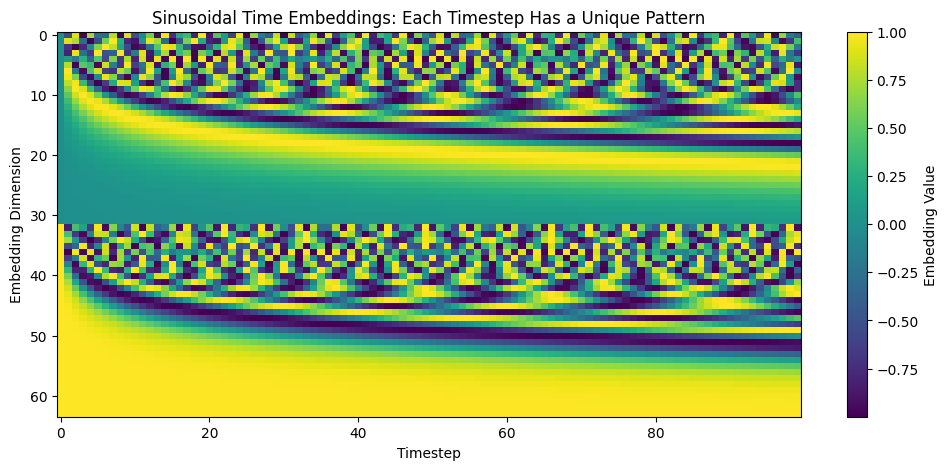

💡 Notice how each timestep has a unique pattern!
   This is how the model knows the current noise level.


In [19]:
class SinusoidalPositionEmbeddings(nn.Module):
    """
    Encode timesteps using sinusoidal embeddings (just like in Transformers!).
    
    This helps the model understand "how noisy" the input is.
    Different frequencies capture different aspects of the timestep.
    """
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        
        # Frequencies: exp(-log(10000) * i / (d/2))
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        
        # Outer product: (B, 1) * (1, d/2) → (B, d/2)
        embeddings = time[:, None] * embeddings[None, :]
        
        # Concatenate sin and cos: (B, d)
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# Visualize the sinusoidal embeddings
dim = 64
emb_layer = SinusoidalPositionEmbeddings(dim)
timesteps = torch.arange(0, T, 10)  # Sample every 10th timestep
embeddings = emb_layer(timesteps)

plt.figure(figsize=(12, 5))
plt.imshow(embeddings.numpy().T, aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.xlabel('Timestep')
plt.ylabel('Embedding Dimension')
plt.title('Sinusoidal Time Embeddings: Each Timestep Has a Unique Pattern')
plt.show()

print("💡 Notice how each timestep has a unique pattern!")
print("   This is how the model knows the current noise level.")

In [20]:
class Block(nn.Module):
    """Basic convolutional block with GroupNorm and SiLU activation."""
    def __init__(self, in_ch, out_ch, groups=8):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm = nn.GroupNorm(groups, out_ch)
        self.act = nn.SiLU()  # SiLU (Swish) works great for diffusion
    
    def forward(self, x):
        return self.act(self.norm(self.conv(x)))


class ResnetBlock(nn.Module):
    """
    Residual block with time embedding injection.
    
    The time embedding is added to the intermediate features,
    allowing the network to adapt based on noise level.
    """
    def __init__(self, in_ch, out_ch, time_emb_dim, groups=8):
        super().__init__()
        self.block1 = Block(in_ch, out_ch, groups)
        self.block2 = Block(out_ch, out_ch, groups)
        
        # Project time embedding
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        
        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    
    def forward(self, x, time_emb):
        h = self.block1(x)
        
        # Add time embedding (broadcast over spatial dimensions)
        h = h + self.time_mlp(time_emb)[:, :, None, None]
        
        h = self.block2(h)
        return h + self.skip(x)


class Attention(nn.Module):
    """Self-attention for capturing long-range dependencies."""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = channels // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
    
    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        qkv = self.qkv(h).reshape(B, 3, self.num_heads, self.head_dim, H * W)
        q, k, v = qkv[:, 0], qkv[:, 1], qkv[:, 2]
        
        attn = torch.einsum('bnci,bncj->bnij', q, k) * self.scale
        attn = attn.softmax(dim=-1)
        out = torch.einsum('bnij,bncj->bnci', attn, v)
        out = out.reshape(B, C, H, W)
        
        return x + self.proj(out)


print("✅ Building blocks defined: Block, ResnetBlock, Attention")

✅ Building blocks defined: Block, ResnetBlock, Attention


In [21]:
class SimpleUNet(nn.Module):
    """
    Simplified U-Net for diffusion models.
    
    Architecture:
        Encoder: [64] → [128] → [256] → [256] (bottleneck)
        Decoder: [256] → [128] → [64] → output
    
    Features:
        - Time embeddings injected at every resolution
        - Skip connections between encoder and decoder
        - Attention at the bottleneck (lowest resolution)
    """
    def __init__(self, in_channels=1, out_channels=1, base_channels=64):
        super().__init__()
        
        # Time embedding
        time_dim = base_channels * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(base_channels),
            nn.Linear(base_channels, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )
        
        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        # Encoder (downsampling)
        self.down1 = ResnetBlock(base_channels, base_channels, time_dim)
        self.down2 = ResnetBlock(base_channels, base_channels * 2, time_dim)
        self.pool1 = nn.Conv2d(base_channels, base_channels, 3, stride=2, padding=1)
        self.pool2 = nn.Conv2d(base_channels * 2, base_channels * 2, 3, stride=2, padding=1)
        
        # Bottleneck with attention
        self.mid1 = ResnetBlock(base_channels * 2, base_channels * 4, time_dim)
        self.mid_attn = Attention(base_channels * 4)
        self.mid2 = ResnetBlock(base_channels * 4, base_channels * 4, time_dim)
        
        # Decoder (upsampling)
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, stride=2, padding=1)
        self.up_block1 = ResnetBlock(base_channels * 4, base_channels * 2, time_dim)  # +skip
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 4, stride=2, padding=1)
        self.up_block2 = ResnetBlock(base_channels * 2, base_channels, time_dim)  # +skip
        
        # Output
        self.final = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, 1)
        )
    
    def forward(self, x, t):
        """
        Args:
            x: Noisy images, shape (B, C, H, W)
            t: Timesteps, shape (B,)
        
        Returns:
            Predicted noise, shape (B, C, H, W)
        """
        # Time embedding
        t_emb = self.time_mlp(t)
        
        # Initial conv
        x = self.init_conv(x)  # (B, 64, 32, 32)
        
        # Encoder
        h1 = self.down1(x, t_emb)      # (B, 64, 32, 32)
        h1_pool = self.pool1(h1)       # (B, 64, 16, 16)
        h2 = self.down2(h1_pool, t_emb) # (B, 128, 16, 16)
        h2_pool = self.pool2(h2)       # (B, 128, 8, 8)
        
        # Bottleneck
        h = self.mid1(h2_pool, t_emb)  # (B, 256, 8, 8)
        h = self.mid_attn(h)
        h = self.mid2(h, t_emb)
        
        # Decoder with skip connections
        h = self.up1(h)                # (B, 128, 16, 16)
        h = torch.cat([h, h2], dim=1)  # (B, 256, 16, 16)
        h = self.up_block1(h, t_emb)   # (B, 128, 16, 16)
        
        h = self.up2(h)                # (B, 64, 32, 32)
        h = torch.cat([h, h1], dim=1)  # (B, 128, 32, 32)
        h = self.up_block2(h, t_emb)   # (B, 64, 32, 32)
        
        return self.final(h)

# Create the model
model = SimpleUNet(in_channels=1, out_channels=1, base_channels=64).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"🧠 Model created with {num_params:,} parameters")
print(f"   Input: (B, 1, 32, 32) → Output: (B, 1, 32, 32)")

🧠 Model created with 4,417,409 parameters
   Input: (B, 1, 32, 32) → Output: (B, 1, 32, 32)


## Section 6: Define the Loss Function

### The Simplest Possible Loss 🎯

The training objective is **surprisingly simple** - just MSE between true and predicted noise!

$$\boxed{L = \mathbb{E}_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]}$$

### Breaking Down the Expectation

The loss averages over three random variables:

| Variable | Sampling | Purpose |
|----------|----------|---------|
| $x_0$ | From dataset | Clean training images |
| $t$ | $\sim \text{Uniform}(0, T)$ | Random noise level |
| $\epsilon$ | $\sim \mathcal{N}(0, I)$ | Random noise to add |

### Training Step (One Iteration)

```python
1. x_0 = get_batch_from_dataloader()      # Clean images
2. t = random_integers(0, T, batch_size)   # Random timesteps  
3. ε = random_normal(shape=x_0.shape)      # Random noise
4. x_t = √ᾱ_t * x_0 + √(1-ᾱ_t) * ε        # Add noise
5. ε̂ = model(x_t, t)                       # Predict noise
6. loss = MSE(ε, ε̂)                        # Compare
7. loss.backward()                         # Backprop
8. optimizer.step()                        # Update weights
```

### Why Does This Simple Loss Work?

1. **Denoising score matching**: This loss is equivalent to learning the score function ∇log p(x)
2. **Variational bound**: Optimizing this loss optimizes a bound on log-likelihood
3. **All timesteps matter**: Network sees every noise level during training

### Expected Loss Values

| Training Stage | Loss Value | Interpretation |
|----------------|------------|----------------|
| Random init | ~1.0 | Predicting random noise |
| Early training | 0.5 - 0.2 | Learning structure |
| Converged | 0.02 - 0.05 | Good predictions |

### Variations (Advanced)

- **Weighted loss**: Weight different timesteps differently
- **v-prediction**: Predict velocity instead of noise
- **x-prediction**: Predict clean image directly

In [25]:
def compute_loss(model, x_0, t=None):
    """
    Compute the diffusion training loss.
    
    L = E[||ε - ε_θ(x_t, t)||²]
    
    Args:
        model: The noise prediction network
        x_0: Clean images, shape (B, C, H, W)
        t: Timesteps (optional, sampled if not provided)
    
    Returns:
        loss: MSE between true and predicted noise
    """
    batch_size = x_0.shape[0]
    
    # 1. Sample random timesteps
    if t is None:
        t = torch.randint(0, T, (batch_size,), device=device)
    
    # 2. Sample random noise
    noise = torch.randn_like(x_0)
    
    # 3. Create noisy images using forward process
    x_t, _ = q_sample(x_0, t, noise)
    
    # 4. Predict the noise
    predicted_noise = model(x_t, t)
    
    # 5. Compute MSE loss
    loss = F.mse_loss(predicted_noise, noise)
    
    return loss

# Test the loss function
test_batch = sample_batch[:4].to(device)
test_loss = compute_loss(model, test_batch)
print(f"📉 Test loss (random model): {test_loss.item():.4f}")
print("   (Should be close to 1.0 for random weights, since noise is unit variance)")

📉 Test loss (random model): 1.1479
   (Should be close to 1.0 for random weights, since noise is unit variance)


## Section 7: Training Loop Implementation

### Training Strategy 🏋️

Training diffusion models is straightforward but requires attention to details:

### Key Hyperparameters

| Parameter | Our Value | Typical Range | Notes |
|-----------|-----------|---------------|-------|
| Batch size | 128 | 64-256 | Larger = more stable gradients |
| Learning rate | 1e-3 | 1e-4 to 2e-4 | Lower for larger models |
| Optimizer | AdamW | Adam/AdamW | Weight decay helps |
| Epochs | 10 | 100-1000 | More = better quality |
| Gradient clipping | 1.0 | 1.0 | Prevents exploding gradients |

### Training Techniques (What We Use)

1. **Random timestep sampling**: Each batch trains on random $t$ values
   - Ensures model sees all noise levels equally
   
2. **Gradient clipping**: Cap gradient norm at 1.0
   - Prevents training instability
   
3. **Cosine LR schedule**: Learning rate decays smoothly
   - Better convergence than constant LR

### Advanced Techniques (Not Used Here)

| Technique | Benefit | Complexity |
|-----------|---------|------------|
| **EMA** (Exponential Moving Average) | Smoother, better samples | Low |
| **Mixed Precision** (FP16) | 2x faster training | Medium |
| **Gradient Accumulation** | Effective larger batches | Low |
| **Classifier-Free Guidance** | Controllable generation | Medium |

### What to Expect During Training

- **Epoch 1**: Loss drops from ~1.0 to ~0.3
- **Epoch 5**: Loss around ~0.1, blurry samples
- **Epoch 20+**: Loss ~0.05, recognizable digits
- **Epoch 100+**: Loss ~0.02, high-quality samples

### Common Issues & Solutions

| Problem | Cause | Solution |
|---------|-------|----------|
| Loss stuck at 1.0 | Learning rate too low | Increase LR |
| Loss explodes (NaN) | LR too high, no clipping | Add gradient clipping |
| Blurry samples | Undertrained | Train longer |
| Mode collapse | Rare in diffusion | Check data pipeline |

/tmp/ipykernel_22946/978763103.py:46: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_22946/978763103.py:46: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/f/Workspaces/virtual-avatar/diffusion-from-scratch/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/mnt/f/Workspaces/virtual-avatar/diffusion-from-scratch/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


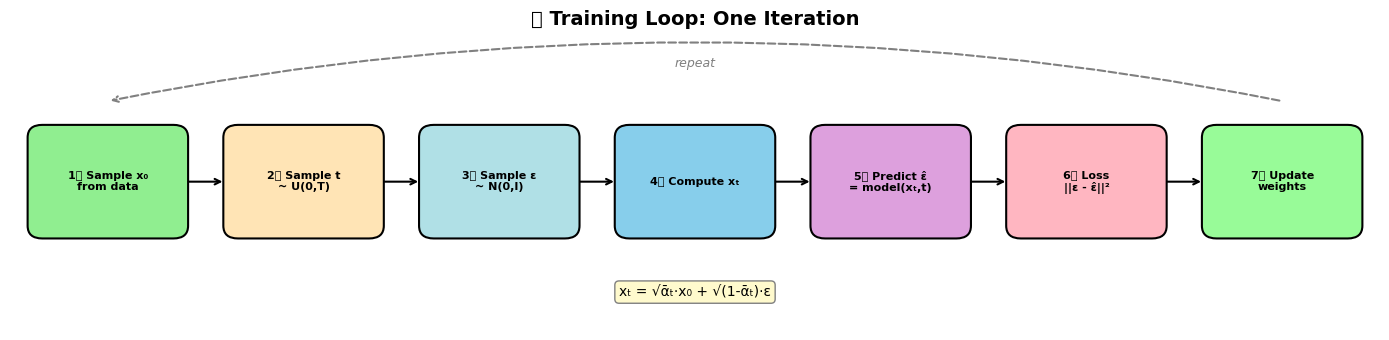

In [26]:
# Visualize the Training Loop Flow using matplotlib
def create_training_diagram():
    """Create a diagram showing the training process."""
    fig, ax = plt.subplots(figsize=(14, 3.5))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 3.5)
    ax.axis('off')
    
    # Training steps
    steps = [
        (1, 1.75, '1️⃣ Sample x₀\nfrom data', '#90EE90'),
        (3, 1.75, '2️⃣ Sample t\n~ U(0,T)', '#FFE4B5'),
        (5, 1.75, '3️⃣ Sample ε\n~ N(0,I)', '#B0E0E6'),
        (7, 1.75, '4️⃣ Compute xₜ', '#87CEEB'),
        (9, 1.75, '5️⃣ Predict ε̂\n= model(xₜ,t)', '#DDA0DD'),
        (11, 1.75, '6️⃣ Loss\n||ε - ε̂||²', '#FFB6C1'),
        (13, 1.75, '7️⃣ Update\nweights', '#98FB98'),
    ]
    
    # Draw boxes
    for x, y, label, color in steps:
        box = FancyBboxPatch((x-0.8, y-0.65), 1.6, 1.3,
                              boxstyle="round,pad=0.02,rounding_size=0.15",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(box)
        ax.text(x, y, label, ha='center', va='center', fontsize=8, fontweight='bold')
    
    # Draw arrows
    for i in range(len(steps)-1):
        x1 = steps[i][0] + 0.8
        x2 = steps[i+1][0] - 0.8
        ax.annotate('', xy=(x2, 1.75), xytext=(x1, 1.75),
                   arrowprops=dict(arrowstyle='->', color='black', lw=1.5))
    
    # Loop back arrow
    ax.annotate('', xy=(1, 2.7), xytext=(13, 2.7),
               arrowprops=dict(arrowstyle='->', color='gray', lw=1.5, 
                              connectionstyle='arc3,rad=0.1', linestyle='--'))
    ax.text(7, 3.1, 'repeat', ha='center', fontsize=9, color='gray', style='italic')
    
    # Formula
    ax.text(7, 0.4, 'xₜ = √ᾱₜ·x₀ + √(1-ᾱₜ)·ε', ha='center', fontsize=10, 
           bbox=dict(boxstyle='round', facecolor='#FFFACD', edgecolor='gray'))
    
    plt.title('🔄 Training Loop: One Iteration', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = create_training_diagram()
plt.show()

In [27]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 10  # Increase for better results!

# Create data loader
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (optional but helps)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS * len(train_loader))

# Move schedule tensors to device
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)
betas = betas.to(device)
alphas_cumprod = alphas_cumprod.to(device)
posterior_variance = posterior_variance.to(device)
sqrt_recip_alphas = sqrt_recip_alphas.to(device)

print(f"🏃 Training configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Total batches: {len(train_loader) * EPOCHS:,}")

🏃 Training configuration:
   Batch size: 128
   Learning rate: 0.001
   Epochs: 10
   Total batches: 4,690


In [30]:
# Training loop
losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}')
    for batch_idx, (images, _) in enumerate(pbar):
        images = images.to(device)
        
        # Compute loss
        loss = compute_loss(model, images)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (helps stability)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        # Logging
        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    print(f"   Epoch {epoch+1} average loss: {avg_loss:.4f}")

print(f"\n✅ Training complete! Final loss: {losses[-1]:.4f}")

Epoch 1/10: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s, loss=0.0154]


   Epoch 1 average loss: 0.0181


Epoch 2/10: 100%|██████████| 469/469 [00:21<00:00, 21.33it/s, loss=0.0131]


   Epoch 2 average loss: 0.0173


Epoch 3/10: 100%|██████████| 469/469 [00:22<00:00, 20.61it/s, loss=0.0165]


   Epoch 3 average loss: 0.0166


Epoch 4/10: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s, loss=0.0180]


   Epoch 4 average loss: 0.0160


Epoch 5/10: 100%|██████████| 469/469 [00:23<00:00, 19.99it/s, loss=0.0094]


   Epoch 5 average loss: 0.0156


Epoch 6/10: 100%|██████████| 469/469 [00:21<00:00, 21.76it/s, loss=0.0223]


   Epoch 6 average loss: 0.0155


Epoch 7/10: 100%|██████████| 469/469 [00:22<00:00, 20.80it/s, loss=0.0185]


   Epoch 7 average loss: 0.0154


Epoch 8/10: 100%|██████████| 469/469 [00:22<00:00, 20.79it/s, loss=0.0145]


   Epoch 8 average loss: 0.0154


Epoch 9/10: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s, loss=0.0141]


   Epoch 9 average loss: 0.0157


Epoch 10/10: 100%|██████████| 469/469 [00:22<00:00, 20.74it/s, loss=0.0137]

   Epoch 10 average loss: 0.0157

✅ Training complete! Final loss: 0.0137


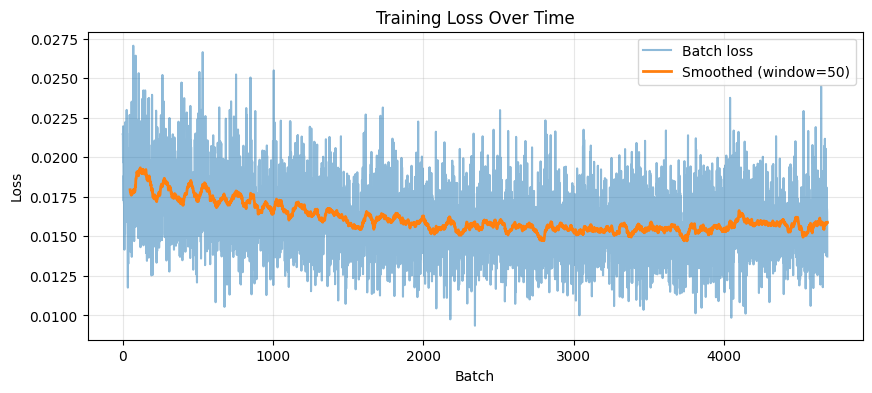

📊 Loss should decrease from ~1.0 (random) to ~0.02-0.05 (trained)


In [31]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.5, label='Batch loss')

# Smoothed loss
window = 50
smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
plt.plot(range(window-1, len(losses)), smoothed, label=f'Smoothed (window={window})', linewidth=2)

plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("📊 Loss should decrease from ~1.0 (random) to ~0.02-0.05 (trained)")

## Section 8: Sampling from the Trained Model

### Generation Algorithm 🎨

Now the exciting part - **generating new images from scratch!**

### DDPM Sampling Algorithm

```
Algorithm: DDPM Sampling
─────────────────────────
Input: Trained model ε_θ, number of steps T
Output: Generated image x_0

1. x_T ~ N(0, I)                    # Start from pure noise
2. for t = T-1, T-2, ..., 1, 0:
3.     ε̂ = ε_θ(x_t, t)              # Predict noise
4.     μ_t = (1/√α_t)(x_t - β_t/√(1-ᾱ_t)·ε̂)  # Compute mean
5.     if t > 0:
6.         z ~ N(0, I)              # Sample noise
7.         x_{t-1} = μ_t + σ_t·z    # Add stochasticity
8.     else:
9.         x_{t-1} = μ_t            # Final step: no noise
10. return x_0
```

### Understanding Each Step

| Step | What Happens | Why |
|------|--------------|-----|
| Start from noise | $x_T \sim \mathcal{N}(0, I)$ | No information about output |
| Predict noise | $\hat{\epsilon} = \epsilon_\theta(x_t, t)$ | Model estimates what noise was "added" |
| Compute mean | Reverse the forward equation | Remove predicted noise |
| Add noise | $x_{t-1} = \mu_t + \sigma_t z$ | Stochasticity improves diversity |
| Final step | No noise added | Clean output |

### Why 1000 Steps?

- **Quality**: More steps = more gradual denoising = better quality
- **Theory**: Matches the forward process (1000 steps of adding noise)
- **Trade-off**: Slower generation (1000 network calls!)

### Sampling Speed

| Method | Steps | Quality | Speed |
|--------|-------|---------|-------|
| DDPM | 1000 | Best | Slow (baseline) |
| DDIM | 50-100 | Near-best | 10-20x faster |
| DPM-Solver | 20-50 | Great | 20-50x faster |
| Consistency Models | 1-4 | Good | 250-1000x faster |

### The Variance Schedule for Sampling

We use **posterior variance**:
$$\tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t$$

This is theoretically optimal when our model perfectly predicts noise.

/tmp/ipykernel_22946/2362632067.py:43: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/f/Workspaces/virtual-avatar/diffusion-from-scratch/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


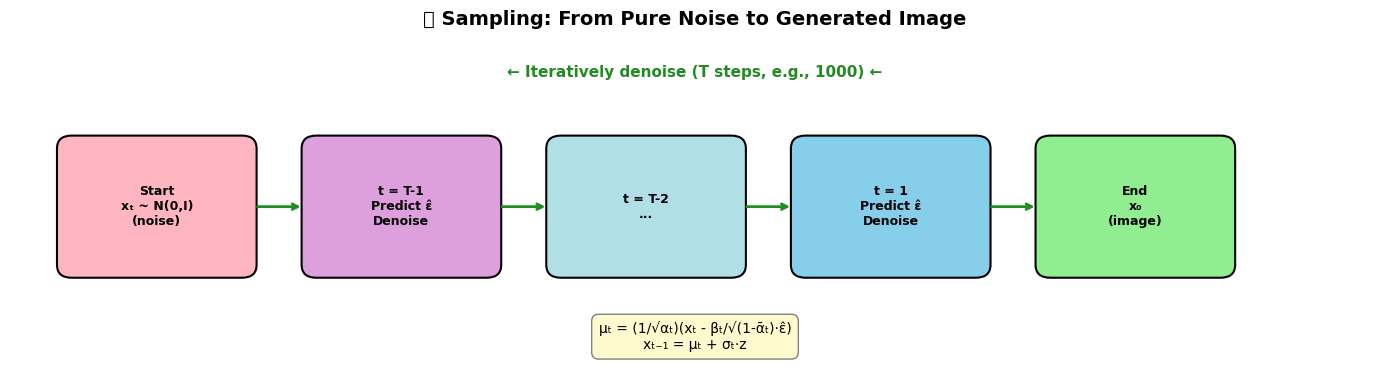

In [32]:
# Visualize the Sampling Process using matplotlib
def create_sampling_diagram():
    """Create a diagram showing the sampling/generation process."""
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.set_xlim(0, 14)
    ax.set_ylim(0, 4)
    ax.axis('off')
    
    # Sampling steps
    steps = [
        (1.5, 2, 'Start\nxₜ ~ N(0,I)\n(noise)', '#FFB6C1'),
        (4, 2, 't = T-1\nPredict ε̂\nDenoise', '#DDA0DD'),
        (6.5, 2, 't = T-2\n...', '#B0E0E6'),
        (9, 2, 't = 1\nPredict ε̂\nDenoise', '#87CEEB'),
        (11.5, 2, 'End\nx₀\n(image)', '#90EE90'),
    ]
    
    # Draw boxes
    for x, y, label, color in steps:
        box = FancyBboxPatch((x-1, y-0.8), 2, 1.6,
                              boxstyle="round,pad=0.02,rounding_size=0.15",
                              facecolor=color, edgecolor='black', linewidth=1.5)
        ax.add_patch(box)
        ax.text(x, y, label, ha='center', va='center', fontsize=9, fontweight='bold')
    
    # Draw arrows
    arrow_positions = [(2.5, 3), (5, 5.5), (7.5, 8), (10, 10.5)]
    for i in range(len(steps)-1):
        x1 = steps[i][0] + 1
        x2 = steps[i+1][0] - 1
        ax.annotate('', xy=(x2, 2), xytext=(x1, 2),
                   arrowprops=dict(arrowstyle='->', color='#228B22', lw=2))
    
    # Formula box
    formula = 'μₜ = (1/√αₜ)(xₜ - βₜ/√(1-ᾱₜ)·ε̂)\nxₜ₋₁ = μₜ + σₜ·z'
    ax.text(7, 0.5, formula, ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='#FFFACD', edgecolor='gray', pad=0.5))
    
    ax.text(7, 3.5, '← Iteratively denoise (T steps, e.g., 1000) ←', 
           ha='center', fontsize=11, color='#228B22', fontweight='bold')
    
    plt.title('🎨 Sampling: From Pure Noise to Generated Image', fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

fig = create_sampling_diagram()
plt.show()

In [33]:
@torch.no_grad()
def sample_images(model, n_samples=16, return_intermediates=False):
    """
    Generate new images using the trained model.
    
    Args:
        model: Trained noise prediction network
        n_samples: Number of images to generate
        return_intermediates: If True, return images at multiple timesteps
    
    Returns:
        Generated images (and optionally intermediate steps)
    """
    model.eval()
    
    # Start from pure Gaussian noise
    shape = (n_samples, 1, 32, 32)
    x = torch.randn(shape, device=device)
    
    intermediates = [x.clone()] if return_intermediates else None
    
    # Iteratively denoise
    for t_idx in tqdm(reversed(range(T)), desc='Generating', total=T):
        t = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
        
        # Predict noise
        predicted_noise = model(x, t)
        
        # Get schedule values
        beta_t = extract(betas, t, x.shape)
        sqrt_one_minus_alpha_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alpha_t = extract(sqrt_recip_alphas, t, x.shape)
        
        # Compute mean
        model_mean = sqrt_recip_alpha_t * (
            x - beta_t * predicted_noise / sqrt_one_minus_alpha_cumprod_t
        )
        
        # Add noise (except at t=0)
        if t_idx > 0:
            noise = torch.randn_like(x)
            posterior_var_t = extract(posterior_variance, t, x.shape)
            x = model_mean + torch.sqrt(posterior_var_t) * noise
        else:
            x = model_mean
        
        if return_intermediates and t_idx % 100 == 0:
            intermediates.append(x.clone())
    
    if return_intermediates:
        return x, intermediates
    return x

# Generate samples!
print("🎨 Generating new handwritten digits...")
samples = sample_images(model, n_samples=16)
samples = (samples + 1) / 2  # Denormalize to [0, 1]
samples = samples.clamp(0, 1)

🎨 Generating new handwritten digits...


Generating: 100%|██████████| 1000/1000 [00:04<00:00, 238.63it/s]


/tmp/ipykernel_22946/682684069.py:9: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


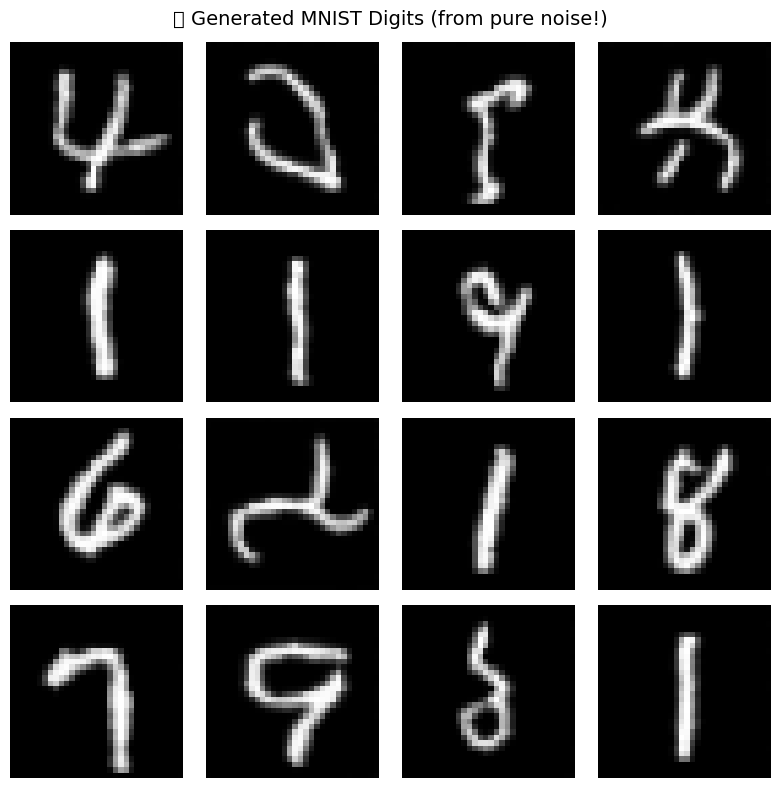


💡 Tips for better results:
   - Train for more epochs (try 50-100)
   - Use larger model (more channels)
   - Try cosine schedule instead of linear


In [34]:
# Display generated samples
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for idx, ax in enumerate(axes.flatten()):
    img = samples[idx, 0].cpu().numpy()
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle('🎨 Generated MNIST Digits (from pure noise!)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n💡 Tips for better results:")
print("   - Train for more epochs (try 50-100)")
print("   - Use larger model (more channels)")
print("   - Try cosine schedule instead of linear")

## Section 9: Visualize the Denoising Process

### Watching the Magic Happen 🔮

Let's visualize how pure noise transforms into recognizable digits step by step!

### What to Observe

| Timestep Range | What You See | What's Happening |
|----------------|--------------|------------------|
| t = 999 → 800 | Pure noise | Model removes high-frequency noise |
| t = 800 → 500 | Blurry blobs | Global structure emerges |
| t = 500 → 200 | Recognizable shapes | Object boundaries form |
| t = 200 → 50 | Clear structure | Fine details added |
| t = 50 → 0 | Final image | Refinement and sharpening |

### The "Coarse-to-Fine" Generation

Diffusion naturally generates images **coarse-to-fine**:
1. **Early steps**: Large-scale decisions (what digit? where?)
2. **Middle steps**: Medium-scale structure (shape, proportions)
3. **Late steps**: Fine details (edges, textures)

This is similar to how artists work - sketch first, then refine!

### Why Different Samples Look Different

Even with the same model:
- **Different starting noise** → Different final images
- **Stochastic sampling** (adding $\sigma_t z$) → Variation in details
- This diversity is a **feature**, not a bug!

🔄 Generating with intermediate steps...


Generating: 100%|██████████| 1000/1000 [00:04<00:00, 230.63it/s]
/tmp/ipykernel_22946/1830557653.py:27: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/f/Workspaces/virtual-avatar/diffusion-from-scratch/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128260 (\N{ANTICLOCKWISE DOWNWARDS AND UPWARDS OPEN CIRCLE ARROWS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


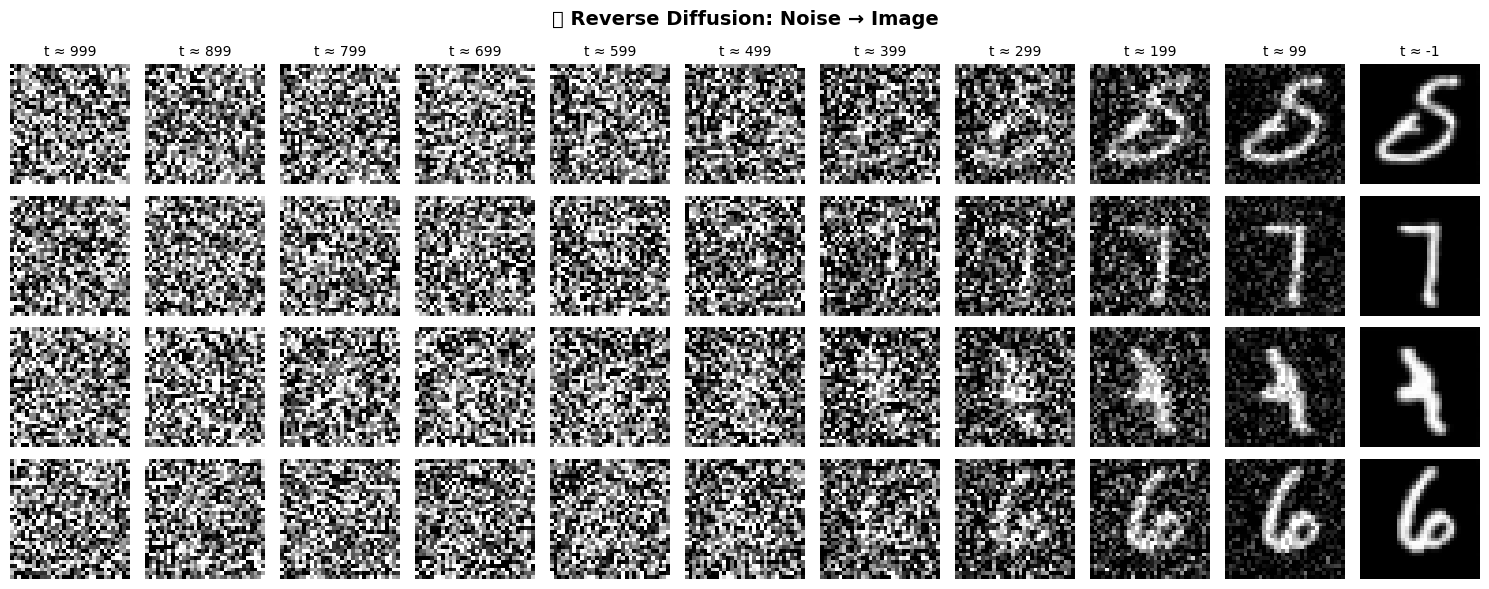


🔍 Observe:
   - High t (left): Mostly noise, structure barely visible
   - Mid t (middle): Structure emerging, shapes forming
   - Low t (right): Clean digit with fine details


In [35]:
# Generate samples with intermediate steps
print("🔄 Generating with intermediate steps...")
final_samples, intermediates = sample_images(model, n_samples=4, return_intermediates=True)

# Visualize the denoising process
n_steps_to_show = len(intermediates)
n_samples_to_show = 4

fig, axes = plt.subplots(n_samples_to_show, n_steps_to_show, figsize=(15, 6))

timesteps_shown = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0][:n_steps_to_show]

for row in range(n_samples_to_show):
    for col, imgs in enumerate(intermediates):
        img = imgs[row, 0].cpu().numpy()
        img = (img + 1) / 2  # Denormalize
        img = np.clip(img, 0, 1)
        
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        
        if row == 0:
            t_val = 999 - col * 100 if col < len(timesteps_shown) else 0
            axes[row, col].set_title(f't ≈ {t_val}', fontsize=10)

plt.suptitle('🔄 Reverse Diffusion: Noise → Image', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Observe:")
print("   - High t (left): Mostly noise, structure barely visible")
print("   - Mid t (middle): Structure emerging, shapes forming")
print("   - Low t (right): Clean digit with fine details")

## 🎓 Summary & What You've Learned

### Core Concepts Mastered

| Concept | What You Learned |
|---------|------------------|
| **Forward Process** | $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$ |
| **Reverse Process** | Neural network predicts $\epsilon_\theta(x_t, t)$ |
| **Noise Schedule** | $\beta_t$, $\alpha_t$, $\bar{\alpha}_t$ control noise levels |
| **U-Net Architecture** | Encoder-decoder with time conditioning |
| **Training** | Simple MSE loss: $\|\epsilon - \epsilon_\theta\|^2$ |
| **Sampling** | Iterative denoising from $x_T$ to $x_0$ |

### Key Insights 💡

1. **Diffusion = Forward (fixed) + Reverse (learned)**
   - Forward process is just math, no learning
   - All the learning happens in the reverse process

2. **Predict noise, not images**
   - Simpler optimization landscape
   - Works at all noise levels

3. **Time embeddings are crucial**
   - Network must know current noise level
   - Sinusoidal encoding gives unique fingerprints

4. **More steps = better quality**
   - 1000 steps is standard, but slower methods exist

### What's Next? 🚀

| Topic | What You'll Learn |
|-------|-------------------|
| **DDIM Sampling** | 50 steps instead of 1000 (20x faster!) |
| **Classifier-Free Guidance** | Control generation with text/labels |
| **Latent Diffusion** | Work in compressed space (Stable Diffusion) |
| **ControlNet** | Add spatial control (pose, edges, depth) |
| **Video Diffusion** | Extend to temporal consistency |

### Resources for Deeper Learning 📚

- **Original DDPM Paper**: Ho et al., "Denoising Diffusion Probabilistic Models" (2020)
- **Improved DDPM**: Nichol & Dhariwal (2021)  
- **Stable Diffusion**: Rombach et al., "High-Resolution Image Synthesis with Latent Diffusion Models"
- **The Annotated Diffusion Model**: Hugging Face blog post

### Exercises to Try 📝

1. **Train longer**: Run for 50+ epochs, observe quality improvement
2. **Try cosine schedule**: Compare with linear schedule
3. **Add class conditioning**: Make the model generate specific digits
4. **Implement DDIM**: Speed up sampling to 50 steps
5. **Try CIFAR-10**: Graduate to RGB color images

---

**Congratulations!** 🎉 You've built a diffusion model from scratch and understand the core concepts behind DALL-E, Stable Diffusion, and Midjourney!

Happy learning and creating! 🎨